<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lesson-6:-pets-revisited" data-toc-modified-id="Lesson-6:-pets-revisited-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lesson 6: pets revisited</a></span><ul class="toc-item"><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data augmentation</a></span></li><li><span><a href="#Train-a-model" data-toc-modified-id="Train-a-model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train a model</a></span></li><li><span><a href="#Convolution-kernel" data-toc-modified-id="Convolution-kernel-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Convolution kernel</a></span><ul class="toc-item"><li><span><a href="#卷积" data-toc-modified-id="卷积-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>卷积</a></span></li></ul></li><li><span><a href="#Heatmap" data-toc-modified-id="Heatmap-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Heatmap</a></span></li><li><span><a href="#Grad-CAM" data-toc-modified-id="Grad-CAM-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Grad-CAM</a></span></li></ul></li></ul></div>

---
本notebook在fastai v3 课程1的notebook基础上，运行出结果后，对相应**知识点进行补充或总结**，同时整理了相应的**xmind文档。**  

<img src="assests/lesson6/lesson6xmind.jpg" width="500">

xmind下载地址[点击这里](https://github.com/greebear/fast.ai-notes/blob/master/xmind/lesson6.xmind) 

---
<font color='green'>
    
**希望达到的效果**
- 回忆录：学过对应内容，浏览一遍nb后，就能快速回忆起知识点
- 优化工具：实践过程中，能在对应的笔记中快速找到调优方法

**学习方法推荐**
- 一边观看fastai视频一遍运行notebook
- 完成学习后，通过xmind笔记回忆所有知识点

<font color='blue'>
    
本notebook的内容与图片参考于：   
- fastai v3 lesson6 notebook [Lesson 6 - pets revisited](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb) 

# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

---
**get_transforms**
- `p_affine`: 仿射变换和对称扭曲的概率
- `p_lighting`：亮度变化的概率
- `max_rotate`：`-max_rotat`到`+max_rotate`之间的旋转角度
- `max_zoom`：缩放，数值大于`1`，缩放概率与`p_affine`相关
- `max_warp`：`-max_warp`和`+max_warp`的图像裁剪，裁剪概率与`p_affine`相关
---
详细文档地址：https://docs.fast.ai/vision.transform.html

**备注：**
-  jeremy提及其中`pad`方法的`reflection`方式是效果最好的。  
    默认会应用此数据增强方法。可以生成更真实更自然的图片。
    消除了`zero_padding`出现的黑边。
- 非常实用的`symmetric_warp`方法，帮助你在kaggle比赛上取得好成绩

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
# doc(get_transforms)

In [6]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
data = get_data(224, bs, 'zeros')

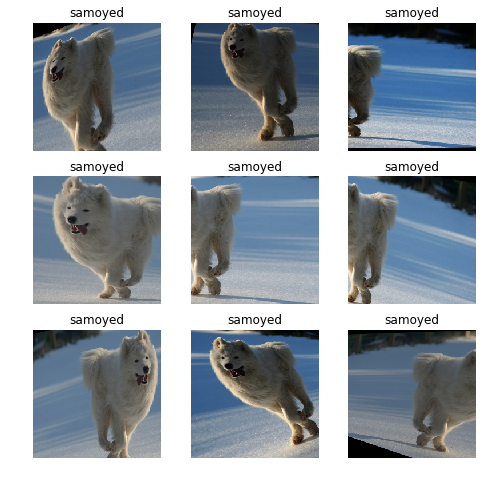

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [10]:
data = get_data(224,bs)

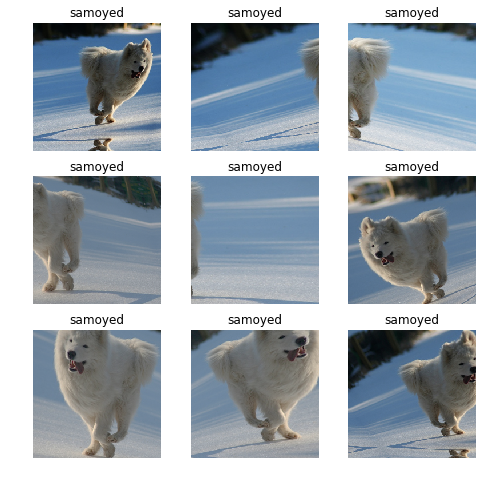

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [12]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 94.5MB/s]


In [13]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.651177,0.365235,0.095399,01:27
1,0.968178,0.283072,0.094046,01:26
2,0.712710,0.245478,0.078484,01:24


In [14]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.583447,0.236115,0.069689,01:26
1,0.533470,0.240175,0.062923,01:26


In [15]:
data = get_data(352,bs)
learn.data = data

In [16]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.512675,0.212987,0.051421,02:30
1,0.484261,0.209967,0.048038,02:36


In [17]:
learn.save('352')

## Convolution kernel

---
### 卷积
- **图像卷积可视化：**
    - 地址：http://setosa.io/ev/image-kernels/  
    
      
- **cnn的另一种视角：**
    - 地址：https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c
    - fastai第一期学员的作品
    
    
- **知识点**
    - 卷积核(kernel)个数等于生成的特征图通道(channel)个数
    - N_new = (N_pre - f + 2*pad)/s + 1
        - N_new：新特征图的宽或高
        - N_pre：上一个特征图的宽或高
        - f：卷积核的大小(宽或高，一般情况下宽高一致)
        - pad：上一个特征图往外(上下左右)填充的像素点个数
        - s：卷积核移动的步长
    - 一般当我们通过步长为2来缩小特征图(宽和高都减半)时，会将卷积核的个数乘以2  
        即特征图宽高减半，特征图通道数增倍。

In [18]:
data = get_data(352,16)

In [19]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category japanese_chin

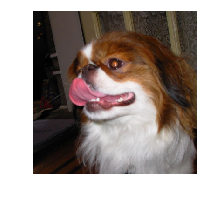

In [20]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

---
重复复制生成三通道kernel，这里三个通道下的kernel都指向同一个内存地址，这是一种高效使用内存的复制方式。  
这里[1, 3 , 3 , 3]代表1个3通道的3*3卷积核

In [21]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [23]:
k.shape

torch.Size([1, 3, 3, 3])

In [24]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

---
- [1, 3, 352, 352]代表batchsize为1的3通道352*352数据图片
- 不管是pytorch还是numpy，都可以用t[None]来增加一个维度，且数量为1

In [25]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [26]:
edge = F.conv2d(t[None], k)

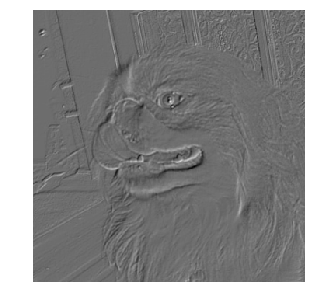

In [27]:
show_image(edge[0], figsize=(5,5));

In [28]:
data.c

37

In [29]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [30]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

**平均池化(average pooling)**
- 从Conv2d到AdaptiveAvgPool2d的过程
- 例子：
    Conv2d               [512, 11, 11]
    AdaptiveAvgPool2d    [512, 1, 1] 
- 将每张特征图一个通道下的像素点(11*11)求平均得到一个像素点(1)  
  
**热力图生成**
- 不同于平均池化(average pooling)从Conv2d到AdaptiveAvgPool2d的过程
- 我们将Conv2d的特征图沿着通道的方向取均值
- 例子：
    Conv2d               [512, 11, 11] 
    heatmap             [1, 11, 11] 

---
learn.model[0]总是模型预训练部分，假如为Resnet34，即输出为[512, 11, 11]

In [31]:
m = learn.model.eval();

---
对于我们送入网络的一张图片需要做的处理:
- 归一化  
- 转成小批量  
- 链接GPU

In [32]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [33]:
from fastai.callbacks.hooks import *

---
**hook:**
- 来自pytorch的一个较高级功能
- 帮助我们链接到pytorch的内部并运行任意python程序

我们通过hook链接到pytorch前向传播(forward)的过程，让pytorch将中间结果也保存下来。

In [34]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [35]:
hook_a,hook_g = hooked_backward()

---
acts 是最后一层卷积(Conv2d)的输出特征图([512, 11, 11])

In [36]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

---
对 [512, 11, 11] 的第0维取均值

In [37]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

---
- `alpha=0.6`透明度设置
- `extent=(0,352,352,0`将图片由11*11 resize成352*352
- `interpolation='bilinear'`采用线性插值

In [38]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

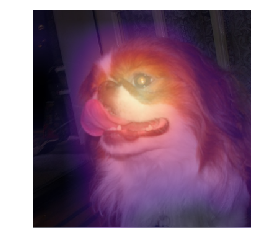

In [39]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [40]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [41]:
mult = (acts*grad_chan[...,None,None]).mean(0)

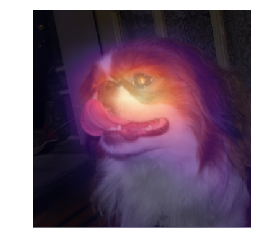

In [42]:
show_heatmap(mult)

In [52]:
fn = path/'staffordshire_bull_terrier_12.jpg' #Replace with your own image

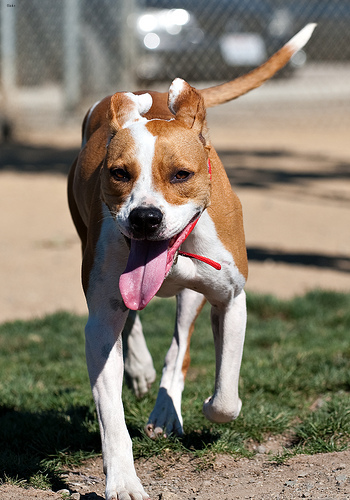

In [54]:
x = open_image(fn); x

In [55]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [56]:
hook_a,hook_g = hooked_backward()

In [57]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

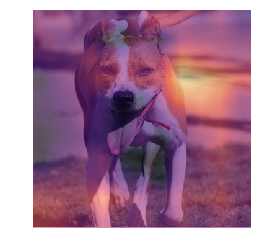

In [58]:
show_heatmap(mult)

In [59]:
data.classes[0]

'Abyssinian'

In [60]:
hook_a,hook_g = hooked_backward(0)

In [61]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

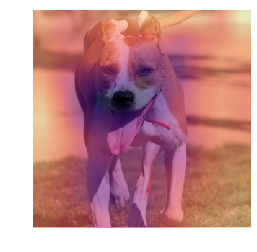

In [62]:
show_heatmap(mult)